In [1]:
import gym

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import math
import random
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from scipy.stats import multivariate_normal
from sklearn import linear_model
# from sklearn.utils.testing import ignore_warnings
# from sklearn.exceptions import ConvergenceWarning
import statsmodels.api as sm
from matplotlib.colors import LogNorm
import pickle

from joblib import Parallel, delayed
import multiprocessing
from collections import namedtuple
from itertools import count

import cProfile
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
# from torch.autograd import Variable

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15, 8)
legend_fontsize = 16

from matplotlib import rc
rc('font', **{'family':'sans-serif'})
# rc('text', usetex=False)
# rc('text.latex',preamble=r'\usepackage[utf8]{inputenc}')
# rc('text.latex',preamble=r'\usepackage[russian]{babel}')
rc('figure', **{'dpi': 300})

In [2]:
from collections import defaultdict
import tqdm

In [3]:
N_ROWS, N_COLS, N_WIN = 3, 3, 3

In [4]:
class TicTacToe(gym.Env):
    def __init__(self, n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN, clone=None):
        if clone is not None:
            self.n_rows, self.n_cols, self.n_win = clone.n_rows, clone.n_cols, clone.n_win
            self.board = copy.deepcopy(clone.board)
            self.curTurn = clone.curTurn
            self.emptySpaces = None
            self.boardHash = None
        else:
            self.n_rows = n_rows
            self.n_cols = n_cols
            self.n_win = n_win

            self.reset()

    def getEmptySpaces(self):
        if self.emptySpaces is None:
            res = np.where(self.board == 0)
            self.emptySpaces = np.array([ (i, j) for i,j in zip(res[0], res[1]) ])
        return self.emptySpaces

    def makeMove(self, player, i, j):
        self.board[i, j] = player
        self.emptySpaces = None
        self.boardHash = None

    def getHash(self):
        if self.boardHash is None:
            self.boardHash = ''.join(['%s' % (x+1) for x in self.board.reshape(self.n_rows * self.n_cols)])
        return self.boardHash

    def isTerminal(self):
        # проверим, не закончилась ли игра
        cur_marks, cur_p = np.where(self.board == self.curTurn), self.curTurn
        for i,j in zip(cur_marks[0], cur_marks[1]):
            win = False
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i:i+self.n_win, j] == cur_p):
                    win = True
            if not win:
                if j <= self.n_cols - self.n_win:
                    if np.all(self.board[i,j:j+self.n_win] == cur_p):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                    if np.all(np.array([ self.board[i+k,j+k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j >= self.n_win-1:
                    if np.all(np.array([ self.board[i+k,j-k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if win:
                self.gameOver = True
                return self.curTurn

        if len(self.getEmptySpaces()) == 0:
            self.gameOver = True
            return 0

        self.gameOver = False
        return None

    def printBoard(self):
        # спасибо Артёму Цуканову
        print('╭', ('───┬' * self.n_cols)[:-1], '╮', sep='')
        for i in range(0, self.n_rows):
            if i != 0:
                print('├', ('───┼' * self.n_cols)[:-1], '┤', sep='')
            out = '│ '
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' │ '
            print(out, sep='')
        print('╰', ('───┴' * self.n_cols)[:-1], '╯', sep='')

    def getState(self):
        return (self.getHash(), self.getEmptySpaces(), self.curTurn)

    def action_from_int(self, action_int):
        return ( int(action_int / self.n_cols), int(action_int % self.n_cols))

    def int_from_action(self, action):
        return action[0] * self.n_cols + action[1]
    
    def step(self, action):
        if self.board[action[0], action[1]] != 0:
            return self.getState(), -10, True, {}
        self.makeMove(self.curTurn, action[0], action[1])
        reward = self.isTerminal()
        self.curTurn = -self.curTurn
        return self.getState(), 0 if reward is None else reward, reward is not None, {}

    def reset(self):
        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.boardHash = None
        self.gameOver = False
        self.emptySpaces = None
        self.curTurn = 1

In [5]:
def plot_board(env, pi, showtext=True, verbose=True, fontq=20, fontx=60):
    '''Рисуем доску с оценками из стратегии pi'''
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    X, Y = np.meshgrid(np.arange(0, env.n_rows), np.arange(0, env.n_rows))
    Z = np.zeros((env.n_rows, env.n_cols)) + .01
    s, actions = env.getHash(), env.getEmptySpaces()
    if pi is not None and s in pi.Q:
        for i, a in enumerate(actions):
            Z[a[0], a[1]] = pi.Q[s][i]
    ax.set_xticks([])
    ax.set_yticks([])
    surf = ax.imshow(Z, cmap=plt.get_cmap('Accent', 10), vmin=-1, vmax=1)
    if showtext:
        for i,a in enumerate(actions):
            if pi is not None and s in pi.Q:
                ax.text( a[1] , a[0] , "%.3f" % pi.Q[s][i], fontsize=fontq,
                        horizontalalignment='center', verticalalignment='center', color="w" )
    for i in range(env.n_rows):
        for j in range(env.n_cols):
            if env.board[i, j] == -1:
                ax.text(j, i, "O", fontsize=fontx, horizontalalignment='center',
                        verticalalignment='center', color="w" )
            if env.board[i, j] == 1:
                ax.text(j, i, "X", fontsize=fontx, horizontalalignment='center',
                        verticalalignment='center', color="w" )
    ax.grid(False)
    plt.show()

def get_and_print_move(env, pi, s, actions, random=False, verbose=True, fontq=20, fontx=60):
    '''Делаем ход, рисуем доску'''
    plot_board(env, pi, fontq=fontq, fontx=fontx)
    if verbose and (pi is not None):
        if s in pi.Q:
            for i,a in enumerate(actions):
                print(i, a, pi.Q[s][i])
        else:
            print("Стратегия не знает, что делать...")
    if random:
        return np.random.randint(len(actions))
    else:
        return pi.getActionGreedy(s, len(actions))

## Часть первая: крестики-нолики при помощи Q-обучения
В коде, прилагающемся к последней лекции про обучение с подкреплением, реализован Environment для крестиков-ноликов, в котором можно при инициализации указывать разные размеры доски и условия победы, а также функции для рисования, в том числе с указанием оценки различных действий. С этим окружением все задания и связаны.


### 1. Реализуйте обычное (табличное) Q-обучение. Обучите стратегии крестиков и ноликов для доски 3х3.

In [6]:
class Agent:
    def __init__(self, action_size):
        pass 

    def act(self, state):
        pass

class DeterministicPolicyAgent(Agent):
    def __init__(self, action_size):
        super().__init__(action_size)
        self.action_size = action_size
        self.Q = defaultdict(lambda: np.zeros(action_size))
        
        self.s = "start"
        self.a = None

    def update_Q(self, reward, s, a):
        self.Q[self.s][self.a] += ALPHA * (reward + GAMMA * np.max(self.Q[s])
                                 - self.Q[self.s][self.a])
        self.a = a
        self.s = s

    def act(self, state):
        return np.argmax(self.Q[state])
    

In [7]:
def available_actions(state):
    array = np.array(list(state))
    return np.where(array == '1')[0]

def not_available_actions(state):
    array = np.array(list(state))
    return np.where(array != '1')[0]

def play_game(env, agent1=None, agent2=None, print_board=False):
    env.reset()
    state, empty_spaces, turn = env.getState()
    done = False
    player = 1
    while not done:
        
        if player == 1:
            if agent1 is None:
                action = random.choice(available_actions(state))
            else:
                action = agent1.act(state)
        elif player == -1:
            if agent2 is None:
                action = random.choice(available_actions(state))
            else:
                action = agent2.act(state)
        else:
            raise Exception("player not 1 or -1")
        action_tuple = env.action_from_int(action)
        (state, empty_spaces, turn), reward, done, _ = env.step(action_tuple)
        if print_board:
            env.printBoard()
        player = player * -1
                    
    if reward == 1:
        result = (1, 0)
    elif reward == -1:
        result = (0, 1)
    else:
        result = (0, 0)
    return result

def evaluate(env, agent1=None, agent2=None, n=1000, disable_tqdm=False):
    rewards1 = []
    rewards2 = []
    for _ in tqdm.notebook.tqdm(range(n), disable=disable_tqdm):
        reward1, reward2 = play_game(env, agent1, agent2, print_board=False)
        rewards1.append(reward1)
        rewards2.append(reward2)
    r1 = np.mean(rewards1)
    r2 = np.mean(rewards2)
    draw = 1 - r1 - r2
    return r1, r2, draw

In [8]:
def Q_learning_episode(env, agent1, agent2):
    env.reset()
    s, empty_spaces, turn = env.getState()
    agents = (agent1, agent2)
    done = False
    agent_idx = 0
    reward = 0
    while not done:
        agent = agents[agent_idx]
        agent.Q[s][not_available_actions(s)] = -1e4
        if random.random() > EPSILON:
            a = agent.act(s) 
        else:
            a = random.choice(available_actions(s))
        agent.update_Q(reward, s, a)
        agent_idx = 1 - agent_idx
        (s, empty_spaces, turn), reward, done, _ = env.step(env.action_from_int(a))
    if reward < -1:
        agent.update_Q(reward, s, a)
    else:
        agent1.update_Q(reward, s, a)
        agent2.update_Q(-reward, s, a)
    

In [9]:
def Q_learning_train(env, agent1, agent2, total_episodes=100_000, n_check=100):
    res_p1 = []
    res_p2 = []
    check_list = []

    for n in tqdm.notebook.tqdm(range(total_episodes)):
        Q_learning_episode(env, agent1, agent2)
        if n % n_check == 0:
            reward_p1 = evaluate(env, agent1=agent1, disable_tqdm=True)[0]
            reward_p2 = evaluate(env, agent2=agent2, disable_tqdm=True)[1]
            res_p1.append(reward_p1)
            res_p2.append(reward_p2)
            check_list.append(n)
    return agent1, agent2, res_p1, res_p2, check_list

In [10]:
for n in tqdm.tqdm_notebook(range(2)):
    None

<ipython-input-10-63a48a760c65>:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for n in tqdm.tqdm_notebook(range(2)):


  0%|          | 0/2 [00:00<?, ?it/s]

In [11]:
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
env.reset()
game_hash, empty_spaces, _ = env.getState()

In [13]:
action_size = len(empty_spaces)
agent_X = DeterministicPolicyAgent(action_size)
agent_O = DeterministicPolicyAgent(action_size)
EPSILON = 0.5
ALPHA = 0.01
GAMMA = 1
res_Q = Q_learning_train(env, agent_X, agent_O, total_episodes=50_000)
agent_X, agent_O, res_p1, res_p2, check_list = res_Q

  0%|          | 0/50000 [00:00<?, ?it/s]

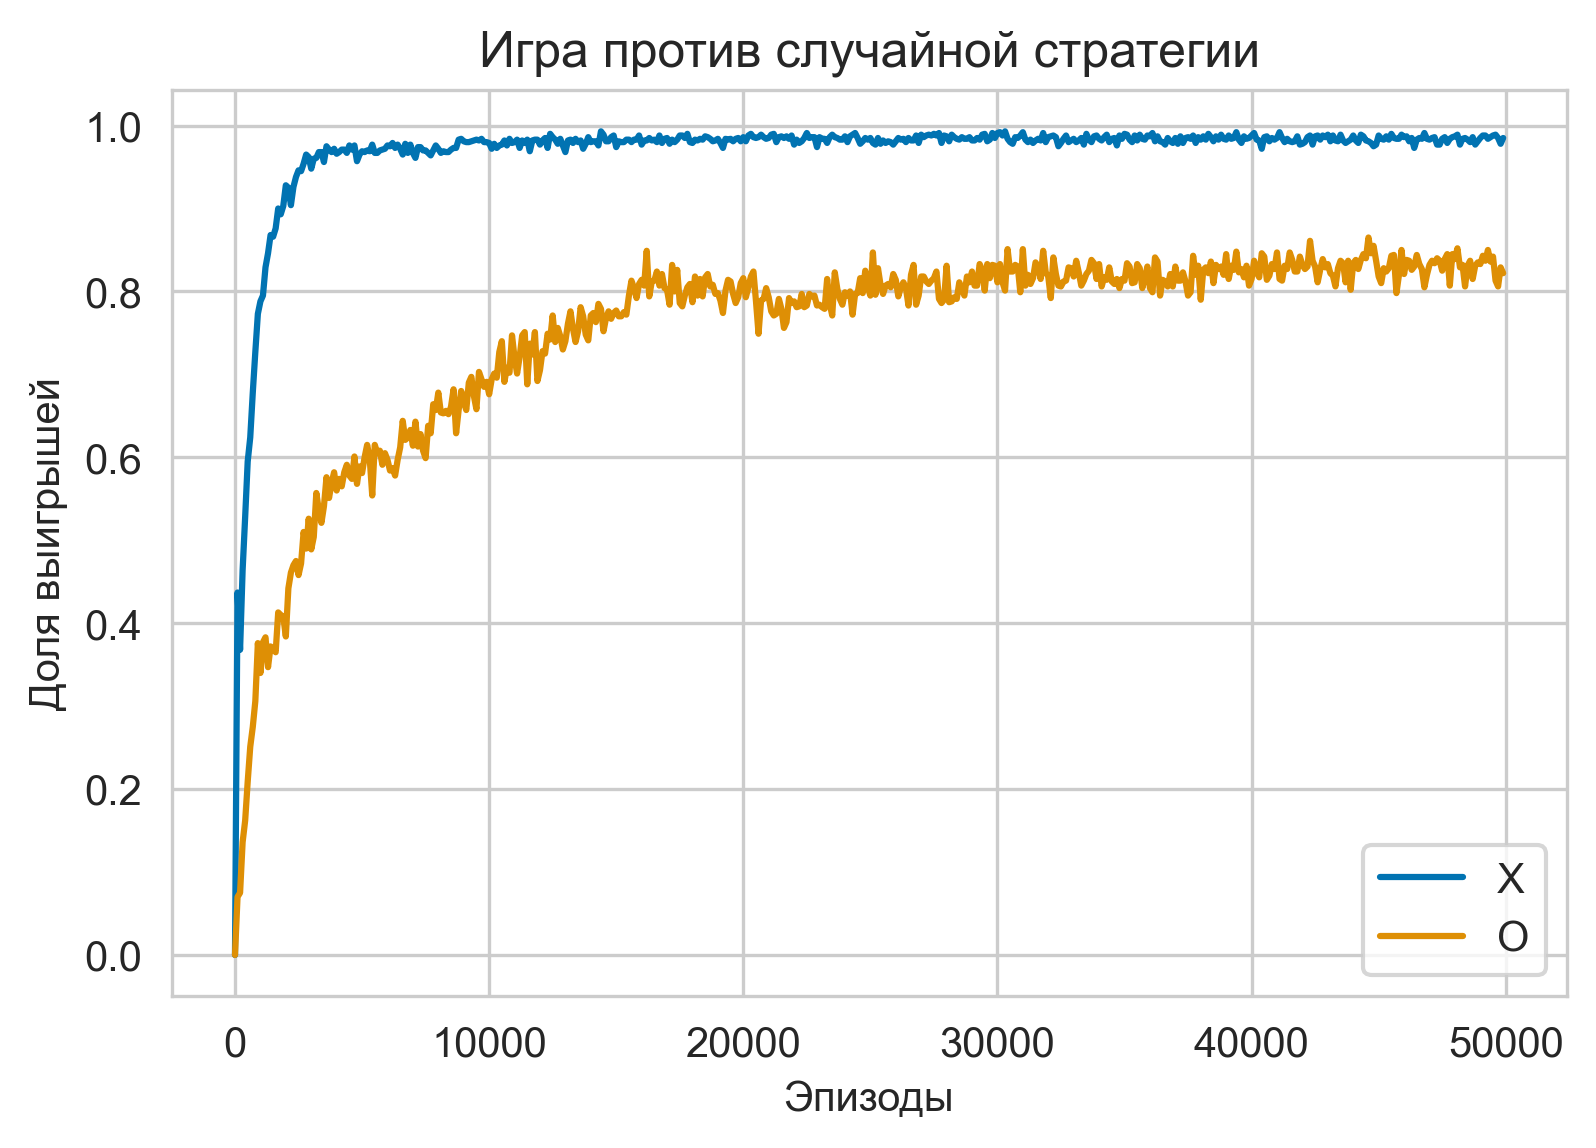

In [14]:
plt.title('Игра против случайной стратегии')
plt.xlabel('Эпизоды')
plt.ylabel('Доля выигрышей')
plt.grid(True)
plt.plot(check_list, res_p1, label="X")
plt.plot(check_list, res_p2, label="O")
plt.legend()
plt.show()

### 2. Попробуйте обучить стратегии крестиков и ноликов для доски 4х4 и/или 5х5.

In [15]:
env = TicTacToe(n_rows=4, n_cols=4, n_win=4)
env.reset()
game_hash, empty_spaces, _ = env.getState()

In [16]:
action_size = len(empty_spaces)
agent_X = DeterministicPolicyAgent(action_size)
agent_O = DeterministicPolicyAgent(action_size)
EPSILON = 0.6
ALPHA = 0.05
GAMMA = 1
res_Q = Q_learning_train(env, agent_X, agent_O, total_episodes=4_000_000, n_check=4_000)
agent_X, agent_O, res_p1, res_p2, check_list = res_Q

  0%|          | 0/4000000 [00:00<?, ?it/s]

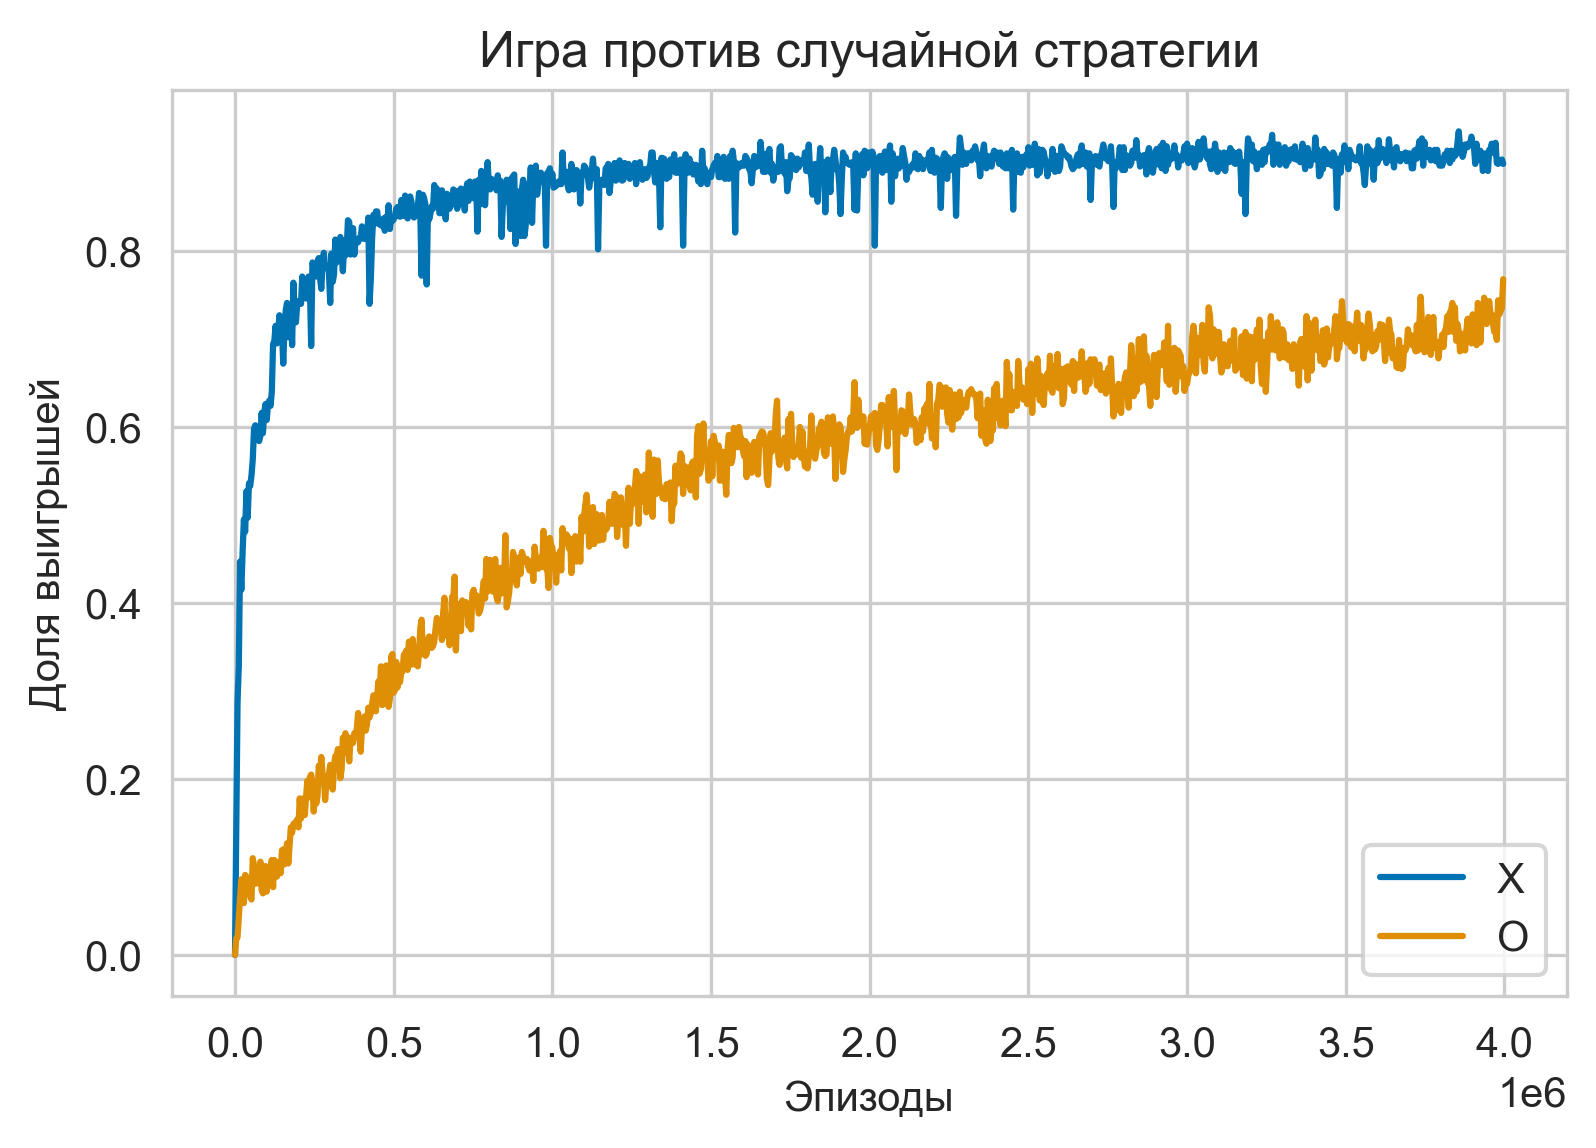

In [17]:
plt.title('Игра против случайной стратегии')
plt.xlabel('Эпизоды')
plt.ylabel('Доля выигрышей')
plt.grid(True)
plt.plot(check_list, res_p1, label="X")
plt.plot(check_list, res_p2, label="O")
plt.legend()
plt.show()

## Часть вторая: добавим нейронных сетей
Реализуйте нейронную сеть для метода DQN на доске для крестиков-ноликов. Не буду ограничивать фантазию, но кажется, что свёртки 3х3 здесь должны неплохо работать (в том числе обобщаться на доски размера побольше).


### 3. Реализуйте DQN с нейронной сетью, обучите стратегии крестиков и ноликов. Замечание: скорее всего, experience replay потребуется сразу же.

In [18]:
class ExpirienceReplay:
    def __init__(self, size=10000):
        self.data = deque(maxlen=size)
    
    def add(self, transition):
        self.data.append(transition)
        
    def sample(self, batch_size):
        batch = random.sample(self.data, batch_size)
        return list(zip(*batch))
#         return batch
    
    def __len__(self):
        return len(self.memory)

In [19]:
class DQNConvModel(nn.Module):
    def __init__(self, action_dim, seed=42):
        super(DQNConvModel, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=128, kernel_size=(3, 3))
        self.fc1 = nn.Linear(128, 128)
        self.fc2 = nn.Linear(128, action_dim) 
        
    def forward(self, state):
        x = self.conv1(state)
        x = F.relu(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        return self.fc2(x)

In [20]:
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.optim import Adam
from collections import deque
import random
import copy

INITIAL_STEPS = 1024 * 4
TRANSITIONS = 100000
STEPS_PER_UPDATE = 4
# STEPS_PER_TARGET_UPDATE = STEPS_PER_UPDATE * 1000
BATCH_SIZE = 256
LEARNING_RATE = 1e-5

EPSILON = 0.5
GAMMA = 1



class DQN:
    def __init__(self, action_dim, batch_size=BATCH_SIZE, experience_replay_size=10000):
        self.steps = 0 
        self.agent_X = DQNConvModel(action_dim).to(device)
        self.agent_O = DQNConvModel(action_dim).to(device)
        self.agents = [self.agent_X, self.agent_O]
        self.buffer_X = ExpirienceReplay(experience_replay_size)
        self.buffer_O = ExpirienceReplay(experience_replay_size)
        self.batch_size = batch_size
        self.optimizer_X = self.optimizer = optim.Adam(self.agent_X.parameters(),
                                                     lr=LEARNING_RATE)
        self.optimizer_O = self.optimizer = optim.Adam(self.agent_O.parameters(),
                                                     lr=LEARNING_RATE)
        self.optimizers = [self.optimizer_X, self.optimizer_O]

    def consume_transition(self, transition, agent_idx):
        if agent_idx == 0:
            self.buffer_X.add(transition)
        elif agent_idx == 1:
            self.buffer_O.add(transition)
        else:
            raise Exception(f"wrong agent_idx: {agent_idx}")
            
    @staticmethod
    def state_to_tensor(state):
        if isinstance(state, str):
            state = [state]
        state = np.array(list(map(lambda x: list(x), state)))
        size = int(np.sqrt(len(state[0])))
        state = np.array([(state == "1").reshape(-1, size, size),
                          (state == "2").reshape(-1, size, size),
                          (state == "0").reshape(-1, size, size)], dtype=np.float32)
        state = torch.tensor(state).transpose(1,0)
        return state

    def sample_batch(self, agent_idx):
        if agent_idx == 0:
            batch = self.buffer_X.sample(self.batch_size)
        elif agent_idx == 1:
            batch = self.buffer_O.sample(self.batch_size)
        else:
            raise Exception(f"wrong agent_idx: {agent_idx}")
        
        state, action, next_state, reward, done = batch
        state = self.state_to_tensor(state).to(device)
        action = torch.tensor(np.array(action, dtype=np.int64)).to(device)
        next_state = self.state_to_tensor(next_state).to(device)
        reward = torch.tensor(np.array(reward, dtype=np.float32)).to(device)
        done = torch.tensor(np.array(done, dtype=np.float32)).to(device)
        return (state, action, next_state, reward, done)
        
    def train_step(self, batch, agent_idx):
        
        states, actions, next_states, rewards, dones = batch
        
        actions = actions.unsqueeze(1)
        rewards = rewards.unsqueeze(1)
        dones = dones.unsqueeze(1)
        policy_model = self.agents[agent_idx]
        optimizer = self.optimizers[agent_idx]
        
        q_targets_next = policy_model(next_states).detach().max(1)[0].unsqueeze(1)
        
        q_targets = rewards + GAMMA * q_targets_next * (1 - dones)
        
        q_expected = policy_model(states).gather(1, actions)
        
        loss = F.smooth_l1_loss(q_expected, q_targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    def act(self, state, agent_idx):
        state = self.state_to_tensor(state).to(device)
        model = self.agents[agent_idx]
        model.eval()
        with torch.no_grad():
            action_values = model(state)
        model.train()
        action = np.argmax(action_values.cpu().data.numpy())
        return action

    def update(self, transition, agent_idx):
        self.consume_transition(transition, agent_idx)
        if self.steps % STEPS_PER_UPDATE == 0:
            batch = self.sample_batch(agent_idx)
            self.train_step(batch, agent_idx)
#         if self.steps % STEPS_PER_TARGET_UPDATE == 0:
#             self.update_target_network()
        self.steps += 1

    def save(self, path="model_state_dict.pkl"):
        torch.save(self.policy_model.state_dict(), path)
    
    def load(self, path="model_state_dict.pkl"):
        self.policy_model.load_state_dict(torch.load(path))


def evaluate(env, dqn, n=1000, disable_tqdm=False):
    rewards1 = []
    rewards2 = []
    for _ in tqdm.notebook.tqdm(range(n), disable=disable_tqdm):
        reward1, reward2 = play_game(env, dqn, agent1=True, print_board=False)
        rewards1.append(reward1)
        rewards2.append(reward2)
    r_x1 = np.mean(rewards1)
    r_x2 = np.mean(rewards2)
    draw_x = 1 - r_x1 - r_x2
    rewards1 = []
    rewards2 = []
    for _ in tqdm.notebook.tqdm(range(n), disable=disable_tqdm):
        reward1, reward2 = play_game(env, dqn, agent2=True, print_board=False)
        rewards1.append(reward1)
        rewards2.append(reward2)
    r_o1 = np.mean(rewards1)
    r_o2 = np.mean(rewards2)
    draw_o = 1 - r_o1 - r_o2
    return r_x1, r_x2, draw_x, r_o1, r_o2, draw_o

def play_game(env, dqn, agent1=None, agent2=None, print_board=False):
    env.reset()
    state, empty_spaces, turn = env.getState()
    done = False
    player = 1
    while not done:
        
        if player == 1:
            if agent1 is None:
                action = random.choice(available_actions(state))
            else:
                action = dqn.act(state, 0)
        elif player == -1:
            if agent2 is None:
                action = random.choice(available_actions(state))
            else:
                action = dqn.act(state, 1)
        else:
            raise Exception("player not 1 or -1")
        action_tuple = env.action_from_int(action)
        (state, empty_spaces, turn), reward, done, _ = env.step(action_tuple)
        if print_board:
            env.printBoard()
        player = player * -1
                    
    if reward == 1:
        result = (1, 0)
    elif reward == -1:
        result = (0, 1)
    else:
        result = (0, 0)
    return result


def train_dqn(env, action_size):
    dqn = DQN(action_dim=action_size)
    env.reset()
    state, empty_spaces, turn = env.getState()
    agent_idx = 0
    history = []
    check_list = []
    
    for _ in range(INITIAL_STEPS):
        action = random.choice(available_actions(state))
        next_obs, reward, done, _ = env.step(env.action_from_int(action))
        next_state = next_obs[0]
        if reward == -1:
            reward = 1
        dqn.consume_transition((state, action, next_state, reward, done), agent_idx)
        if not done:
            state = next_state
            agent_idx = 1 - agent_idx
        else:
            env.reset()
            state, empty_spaces, turn = env.getState()
            agent_idx = 0
        
    
    for i in range(TRANSITIONS):
        # Epsilon-greedy policy
        if random.random() < EPSILON:
            action = random.choice(available_actions(state))
        else:
            action = dqn.act(state, agent_idx)
        next_obs, reward, done, _ = env.step(env.action_from_int(action))
        next_state = next_obs[0]
        if reward == -1 and agent_idx == 1:
            reward = 1
        dqn.update((state, action, next_state, reward, done), agent_idx)
        if not done:
            state = next_state
            agent_idx = 1 - agent_idx
        else:
            env.reset()
            state, empty_spaces, turn = env.getState()
            agent_idx = 0
        
        if (i + 1) % 100 == 0:
            rewards = evaluate(env, dqn, n=200, disable_tqdm=True)
            history.append(rewards)
            check_list.append(i + 1)
#             mean_reward = np.mean(rewards, axis=1)
#             std_reward = np.std(rewards, axis=1)
#             print(f"Step: {i+1}, Reward mean: {mean_reward}, Reward std: {std_reward}")
#             x_wins1, o_wins1, draw1, x_wins2, o_wins2, draw2 = rewards 
#             print(f"Step: {i+1}")
#             print("For x-strategy against random:")
#             print(f"X:{x_wins1}, O:{o_wins1}, drows:{draw1}")
#             print("For o-strategy against random:")
#             print(f"X:{x_wins2}, O:{o_wins2}, drows:{draw2}")
#             if mean_reward > best_reward:
#                 dqn.save("model_state_dict_best.pkl")
#             if mean_reward - std_reward > best_min_reward:
#                 dqn.save("model_state_dict_best_min.pkl")agent_idx
    return check_list, history

In [21]:
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)

device = "cpu"

env.reset()
game_hash, empty_spaces, _ = env.getState()
action_size = len(empty_spaces)

check_list, history = train_dqn(env, action_size)

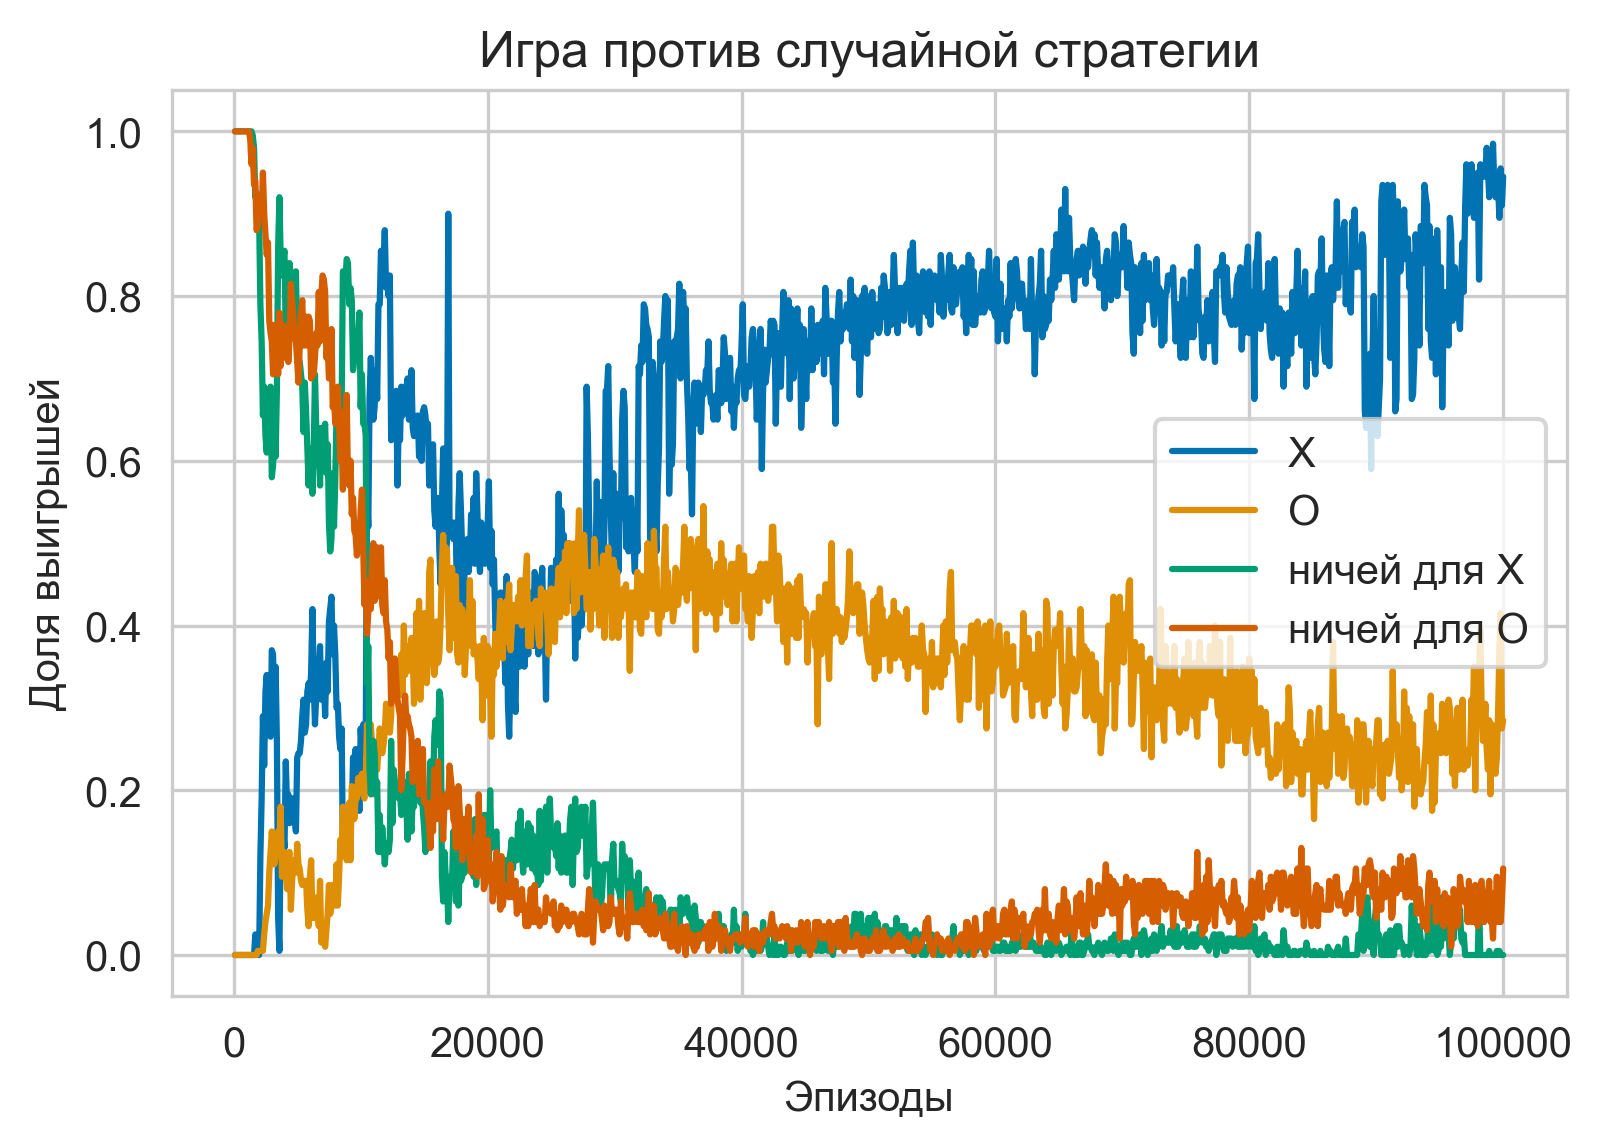

In [22]:
plt.title('Игра против случайной стратегии')
plt.xlabel('Эпизоды')
plt.ylabel('Доля выигрышей')
plt.grid(True)
plt.plot(check_list, np.array(history)[:,0], label="X")
plt.plot(check_list, np.array(history)[:,4], label="O")
plt.plot(check_list, np.array(history)[:,2], label="ничей для X")
plt.plot(check_list, np.array(history)[:,5], label="ничей для O")
plt.legend()
plt.show()

### 4. Реализуйте Double DQN и/или Dueling DQN.

In [23]:
INITIAL_STEPS = 1024 * 4
TRANSITIONS = 100000
STEPS_PER_UPDATE = 4
STEPS_PER_TARGET_UPDATE = STEPS_PER_UPDATE * 10
BATCH_SIZE = 256
LEARNING_RATE = 1e-5

EPSILON = 0.5
GAMMA = 1


class DQN:
    def __init__(self, action_dim, batch_size=BATCH_SIZE, experience_replay_size=10000):
        self.steps = 0 
        self.agent_X = DQNConvModel(action_dim).to(device)
        self.agent_O = DQNConvModel(action_dim).to(device)
        
        self.agent_X_target = DQNConvModel(action_dim).to(device)
        self.agent_O_target = DQNConvModel(action_dim).to(device)
        
        self.agents = [self.agent_X, self.agent_O]
        self.target_nets = [self.agent_X_target, self.agent_O_target]
        self.buffer_X = ExpirienceReplay(experience_replay_size)
        self.buffer_O = ExpirienceReplay(experience_replay_size)
        self.batch_size = batch_size
        self.optimizer_X = self.optimizer = optim.Adam(self.agent_X.parameters(),
                                                     lr=LEARNING_RATE)
        self.optimizer_O = self.optimizer = optim.Adam(self.agent_O.parameters(),
                                                     lr=LEARNING_RATE)
        self.optimizers = [self.optimizer_X, self.optimizer_O]

    def consume_transition(self, transition, agent_idx):
        if agent_idx == 0:
            self.buffer_X.add(transition)
        elif agent_idx == 1:
            self.buffer_O.add(transition)
        else:
            raise Exception(f"wrong agent_idx: {agent_idx}")
            
    @staticmethod
    def state_to_tensor(state):
        if isinstance(state, str):
            state = [state]
        state = np.array(list(map(lambda x: list(x), state)))
        size = int(np.sqrt(len(state[0])))
        state = np.array([(state == "1").reshape(-1, size, size),
                          (state == "2").reshape(-1, size, size),
                          (state == "0").reshape(-1, size, size)], dtype=np.float32)
        state = torch.tensor(state).transpose(1,0)
        return state

    def sample_batch(self, agent_idx):
        if agent_idx == 0:
            batch = self.buffer_X.sample(self.batch_size)
        elif agent_idx == 1:
            batch = self.buffer_O.sample(self.batch_size)
        else:
            raise Exception(f"wrong agent_idx: {agent_idx}")
        
        state, action, next_state, reward, done = batch
        state = self.state_to_tensor(state).to(device)
        action = torch.tensor(np.array(action, dtype=np.int64)).to(device)
        next_state = self.state_to_tensor(next_state).to(device)
        reward = torch.tensor(np.array(reward, dtype=np.float32)).to(device)
        done = torch.tensor(np.array(done, dtype=np.float32)).to(device)
        return (state, action, next_state, reward, done)
        
    def train_step(self, batch, agent_idx):
        
        states, actions, next_states, rewards, dones = batch
        
        actions = actions.unsqueeze(1)
        rewards = rewards.unsqueeze(1)
        dones = dones.unsqueeze(1)
        policy_model = self.agents[agent_idx]
        target_model = self.target_nets[agent_idx]
        optimizer = self.optimizers[agent_idx]

        
        q_targets_next = target_model(next_states).detach().max(1)[0].unsqueeze(1)
        
        q_targets = rewards + GAMMA * q_targets_next * (1 - dones)
        
        q_expected = policy_model(states).gather(1, actions)
        
        loss = F.smooth_l1_loss(q_expected, q_targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    def act(self, state, agent_idx):
        state = self.state_to_tensor(state).to(device)
        model = self.agents[agent_idx]
        model.eval()
        with torch.no_grad():
            action_values = model(state)
        model.train()
        action = np.argmax(action_values.cpu().data.numpy())
        return action

    def update(self, transition, agent_idx):
        self.consume_transition(transition, agent_idx)
        if self.steps % STEPS_PER_UPDATE == 0:
            batch = self.sample_batch(agent_idx)
            self.train_step(batch, agent_idx)
        if self.steps % STEPS_PER_TARGET_UPDATE == 0:
            self.update_target_network()
        self.steps += 1
    
    def update_target_network(self):
        self.agent_X_target.load_state_dict(self.agent_X.state_dict())
        self.agent_O_target.load_state_dict(self.agent_O.state_dict())

    def save(self, path="model_state_dict.pkl"):
        torch.save(self.policy_model.state_dict(), path)
    
    def load(self, path="model_state_dict.pkl"):
        self.policy_model.load_state_dict(torch.load(path))



In [24]:
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)

device = "cpu"

env.reset()
game_hash, empty_spaces, _ = env.getState()
action_size = len(empty_spaces)

check_list, history = train_dqn(env, action_size)

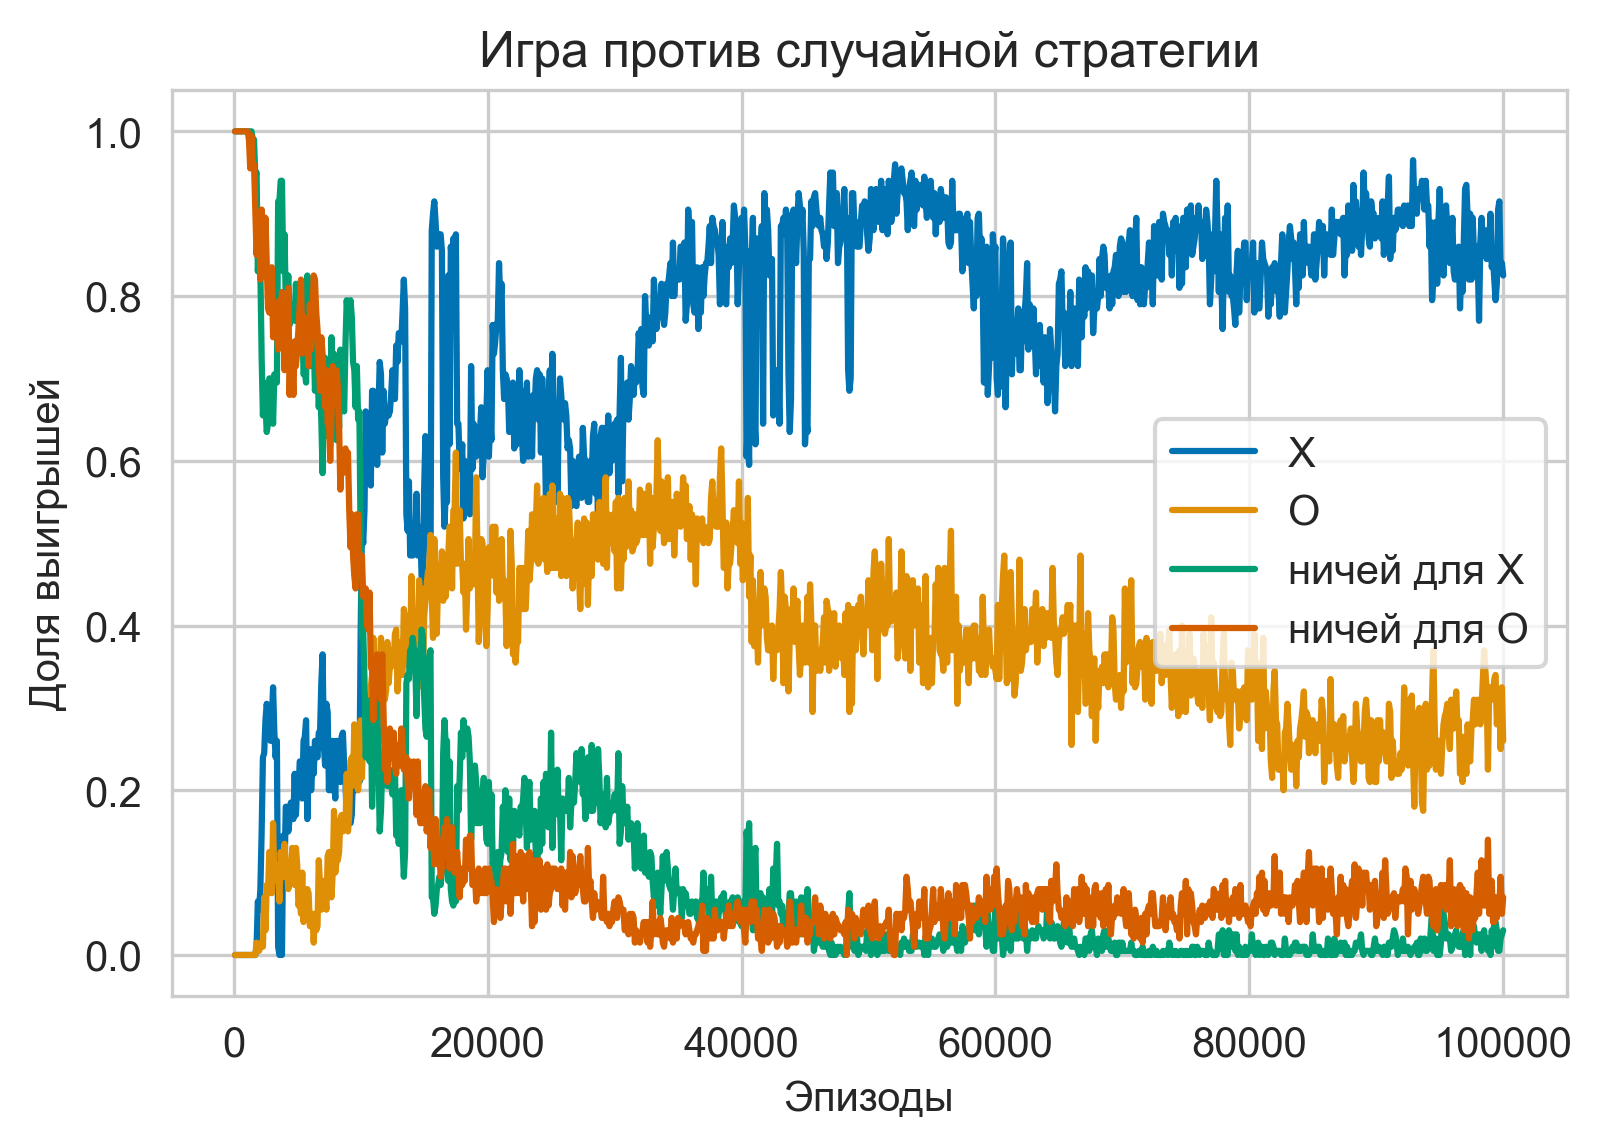

In [25]:
plt.title('Игра против случайной стратегии')
plt.xlabel('Эпизоды')
plt.ylabel('Доля выигрышей')
plt.grid(True)
plt.plot(check_list, np.array(history)[:,0], label="X")
plt.plot(check_list, np.array(history)[:,4], label="O")
plt.plot(check_list, np.array(history)[:,2], label="ничей для X")
plt.plot(check_list, np.array(history)[:,5], label="ничей для O")
plt.legend()
plt.show()

#### Для варианта 4х4

In [282]:
class DQNConvModel(nn.Module):
    def __init__(self, action_dim, seed=42):
        super(DQNConvModel, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3))
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=256, kernel_size=(2, 2))
        self.fc1 = nn.Linear(256, 256)
        self.fc2 = nn.Linear(256, action_dim) 
        
    def forward(self, state):
        x = self.conv1(state)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        return self.fc2(x)

In [285]:
TRANSITIONS = 200000
env = TicTacToe(n_rows=4, n_cols=4, n_win=4)

device = "cpu"

env.reset()
game_hash, empty_spaces, _ = env.getState()
action_size = len(empty_spaces)

check_list, history = train_dqn(env, action_size)

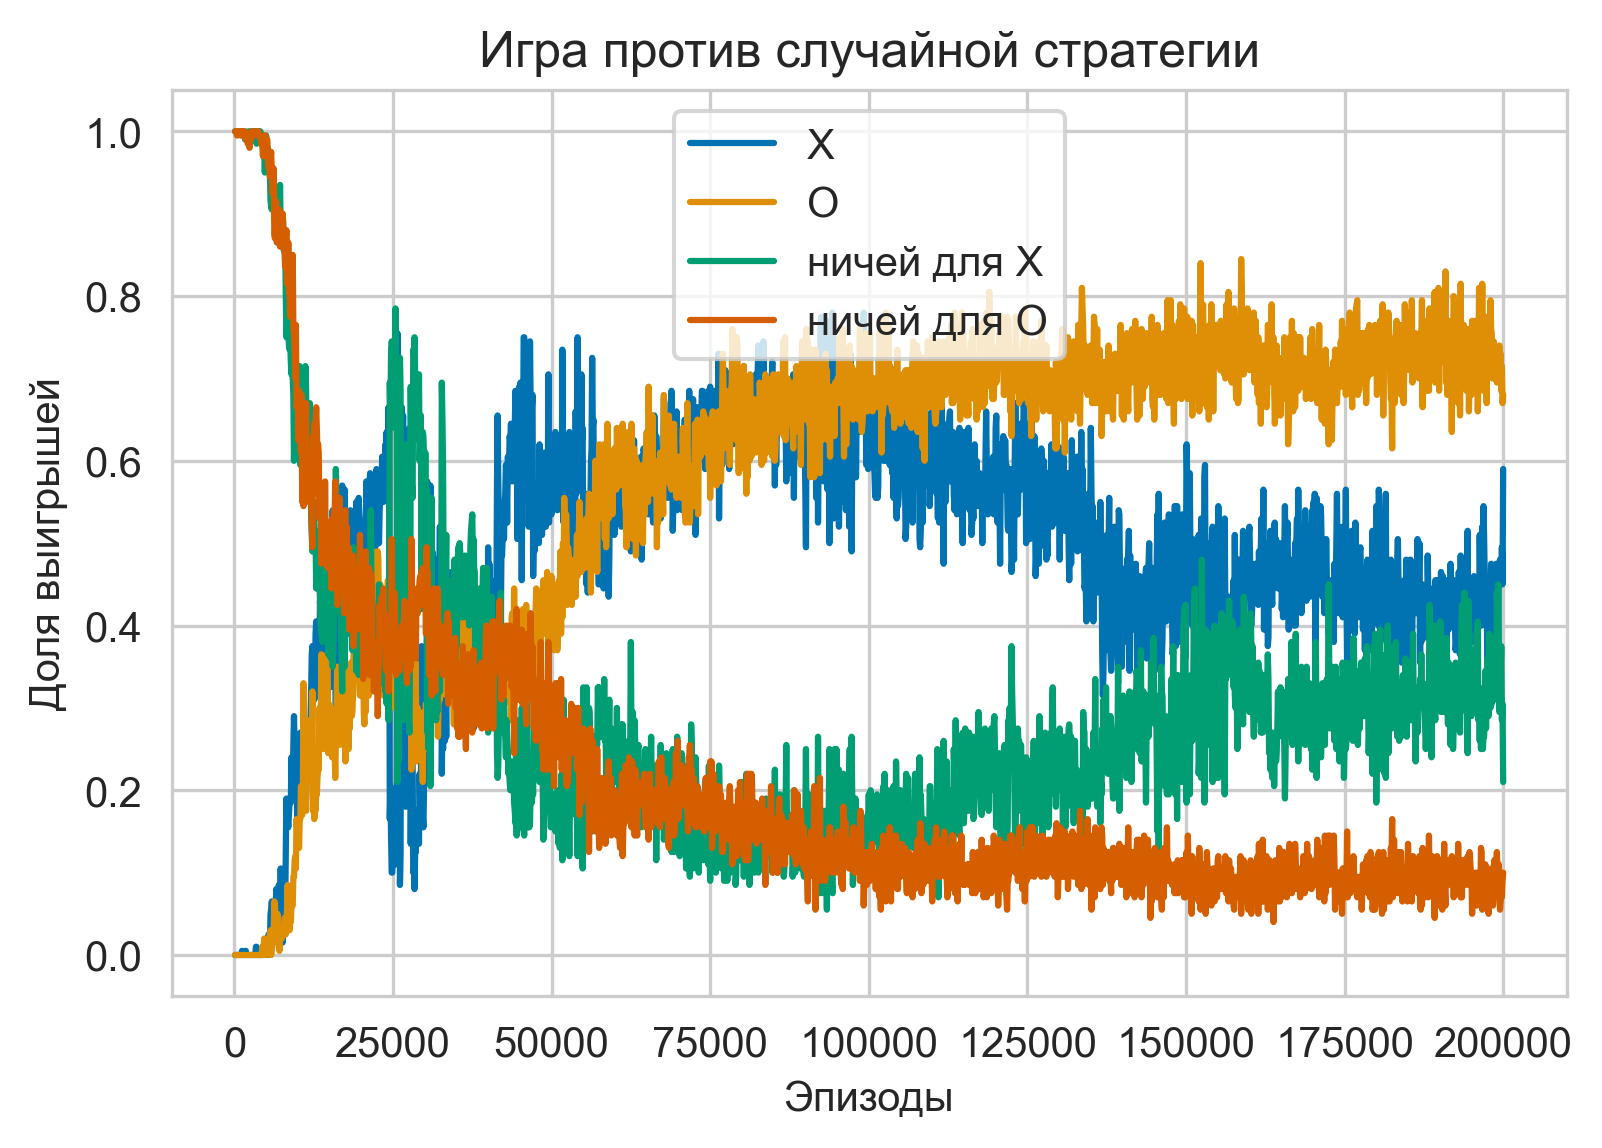

In [286]:
plt.title('Игра против случайной стратегии')
plt.xlabel('Эпизоды')
plt.ylabel('Доля выигрышей')
plt.grid(True)
plt.plot(check_list, np.array(history)[:,0], label="X")
plt.plot(check_list, np.array(history)[:,4], label="O")
plt.plot(check_list, np.array(history)[:,2], label="ничей для X")
plt.plot(check_list, np.array(history)[:,5], label="ничей для O")
plt.legend()
plt.show()